# Topic:        Challenge Set 5
## Subject:      Linear Reg. and Train/Test Split challenges
## Date:         01/28/2018
### Name:         Mauro Mario Gentile

In [1]:
# standard settings
test_size=0.30 
random_state=4444

In [52]:
import re
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import string
import patsy
import pickle
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

In [3]:
df=pd.read_json("mojo.json")
financials=pd.read_csv("budget.csv", encoding="UTF-8", sep="|",header=None)


In [4]:
# clean the dep variable

In [5]:

df["domestic_gross"]=df["domestic_gross"].str.replace("n/a","0")
df["domestic_gross_clnd"]=df["domestic_gross"].apply(lambda x: int(re.sub('['+string.punctuation+']', '', x).strip()))


In [6]:
def clean_budget(x):
    budg_reg=re.compile("\$(.*) million", re.IGNORECASE)
    budg=None
    matches = re.search(budg_reg, x)
    if matches!=None:
            budg=float(matches.group(1))*1000000
    return(budg)
df["budget_cleaned"]=df["budget"].apply( clean_budget)

In [7]:
financials.columns=["name","URL_Numb","Budget_Numb","Domestic_Numb","WWide_Numb","o"]

In [8]:
df["name"]=df["name"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x).replace('  ', ' ').strip().lower())
financials["name"]=financials["name"].apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x).replace('  ', ' ').strip().lower())

In [9]:
del financials["o"]

In [10]:
# merge The Numbers and Mojo db
df=df.merge(financials, on='name',how="left", indicator=True)

In [11]:
# Normalize budget, domand int gross from the Numbers

mask=df["Budget_Numb"].notnull()
df.loc[mask,"Budget_Numb_clnd"]=df.loc[mask,"Budget_Numb"].apply(lambda x: int(re.sub('['+string.punctuation+']', '', x).strip()))

mask=df["Domestic_Numb"].notnull()
df.loc[mask,"Domestic_Numb_clnd"]=df.loc[mask,"Domestic_Numb"].apply(lambda x: 0 if x==0 else int(re.sub('['+string.punctuation+']', '', x).strip()))

mask=df["WWide_Numb"].notnull()
df.loc[mask,"WWide_Numb_clnd"]=df.loc[mask,"WWide_Numb"].apply(lambda x: 0 if x==0 else int(re.sub('['+string.punctuation+']', '', x).strip()))


In [12]:
mask=((df["budget_cleaned"].isnull())&(df["Budget_Numb_clnd"].notnull()))

In [13]:
df.loc[mask, "budget_cleaned"]=df.loc[mask, "Budget_Numb_clnd"]

In [14]:
A=df.groupby(["main_genre"]).median()["budget_cleaned"]
median_budget_by_genre=A.dropna().to_dict()

In [15]:
# Fill N/A in budget as median value of bujet by genre )

In [16]:
df.loc[mask, "budget_cleaned"]=df.loc[mask].apply(lambda row: median_budget_by_genre[row["main_genre"]] if row["main_genre"] in median_budget_by_genre else np.nan,axis=1 )

In [17]:
# I need the release year to adjust financials to tehir 2018 value
df["release_year"]=df["release_date"].apply(lambda x: x.split(" ")[-1].lower())

In [18]:
adjusting_factor_domestic_gross=pickle.load(open( "adjusting_factor_domestic_gross.pkl", "rb" ) )

In [19]:
inflaction_rate=pickle.load(open( "inflaction_rates.pkl", "rb" ) )

In [20]:
mask=df["domestic_gross_clnd"]!=0
df.loc[mask, "domestic_gross_clnd_adj"]=\
 df.loc[mask].apply(lambda row: row["domestic_gross_clnd"]\
                    *adjusting_factor_domestic_gross[row["release_year"]],axis=1)

In [21]:
mask=df["budget_cleaned"]!=0
df.loc[mask, "budget_adj"]=\
 df.loc[mask].apply(lambda row: row["budget_cleaned"]\
                    *inflaction_rate[row["release_year"]],axis=1)

## Challenge 1:
Build a linear model that uses only a constant term (a column of ones) to predict a continuous outcome (like domestic total gross). How can you interpret the results of this model? What does it predict? Make a plot of predictions against actual outcome. Make a histogram of residuals. How are the residuals distributed?

In [22]:

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('domestic_gross_clnd_adj ~ 1', data=df, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit = model.fit()
predicted=fit.predict(X)
# Print summary statistics of the model's performance
fit.summary()

/usr/local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1396: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     domestic_gross_clnd_adj   R-squared:                      -0.000
Model:                                 OLS   Adj. R-squared:                 -0.000
Method:                      Least Squares   F-statistic:                      -inf
Date:                     Sun, 28 Jan 2018   Prob (F-statistic):                nan
Time:                             16:14:52   Log-Likelihood:            -1.9665e+05
No. Observations:                     9993   AIC:                         3.933e+05
Df Residuals:                         9992   BIC:                         3.933e+05
Df Model:                                0                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.884e+07   8.51e+05     45.622      0.000    3.72e+07    4.05e+07
==============================================================================
Omnibus:                    10965.257   Durbin-Watson:                   0.517
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1376204.798
Skew:                           5.469   Prob(JB):                         0.00
Kurtosis:                      59.441   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# the model simply predict the population mean, for any input x.
# As such, the SSR is 0 and consequantly R2 is 0.


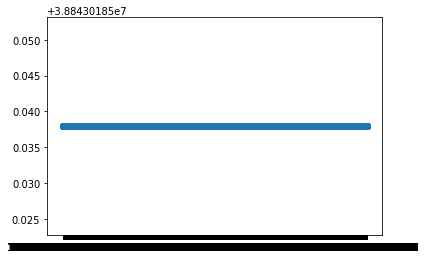

In [24]:
plt.scatter(y,predicted)


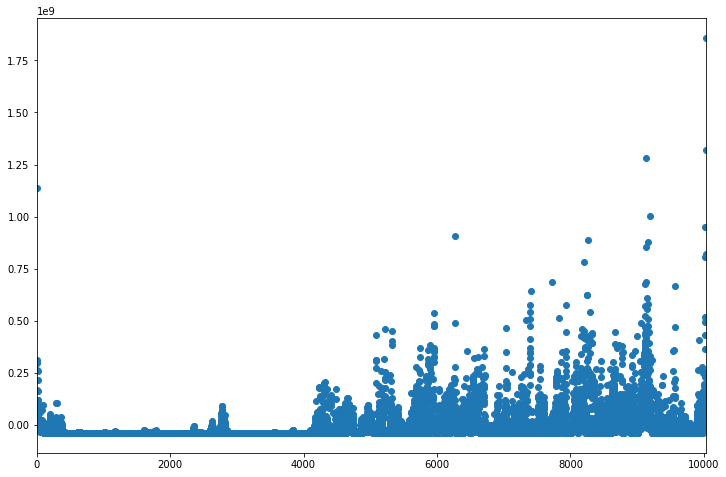

In [25]:
fit.resid.plot(style='o', figsize=(12,8))

In [26]:
# the residual plot is not meeting the assumptions:
# it is not normally distribuited 
# it is not centered around the 0
# It is not homostedatics


## Challenge 2
Repeat the process of challenge one, but also add one continuous (numeric) predictor variable. Also add plots of model prediction against your feature variable and residuals against feature variable. How can you interpret what's happening in the model?


In [27]:

# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('domestic_gross_clnd_adj ~ budget_adj', data=df, return_type="dataframe")
# Create your model
model = sm.OLS(y, X)
# Fit your model to your training set
fit2 = model.fit()
predicted2=fit2.predict(X)
# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     domestic_gross_clnd_adj   R-squared:                       0.251
Model:                                 OLS   Adj. R-squared:                  0.251
Method:                      Least Squares   F-statistic:                     1230.
Date:                     Sun, 28 Jan 2018   Prob (F-statistic):          1.55e-232
Time:                             16:17:37   Log-Likelihood:                -72784.
No. Observations:                     3663   AIC:                         1.456e+05
Df Residuals:                         3661   BIC:                         1.456e+05
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    2.27e+07   2.46e+06      9.227      0.000    1.79e+07    2.75e+07
budget_adj     1.0941      0.031     35.068      0.000       1.033       1.155
==============================================================================
Omnibus:                     3724.759   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           388209.354
Skew:                           4.769   Prob(JB):                         0.00
Kurtosis:                      52.523   Cond. No.                     1.14e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

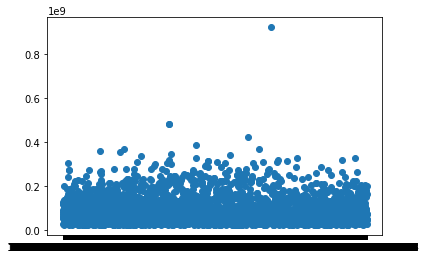

In [28]:
plt.scatter(y,predicted2)

R and adj R2 have imroved. Additionally the p value associated with the budget
variable is less than 5%. This means that the Hypotesis test 
says that it is not insignificant as a predictor (i.e. it rejects the null 
hypotesis of having beta equal to 0)

## Challenge 3
Repeat the process of challenge 1, but add a categorical feature (like genre). You'll have to convert a column of text into a number of numerical columns ("dummy variables"). How can you interpret what's happening in the model?

In [29]:
df['main_genre']=df['main_genre'].str.replace("/","_")
df['main_genre']=df['main_genre'].str.replace(" ","_")
df['main_genre']=df['main_genre'].str.replace("-","_")
dummies = pd.get_dummies(df['main_genre'])
df = pd.concat([df, dummies], axis=1)


In [30]:
genres=df['main_genre'].unique()

In [31]:
str_as_R="domestic_gross_clnd_adj ~ budget_adj+"+"+".join(genres)

In [32]:
y, X = patsy.dmatrices(str_as_R, data=df, return_type="dataframe")

model = sm.OLS(y, X)
# Fit your model to your training set
fit3 = model.fit()
predicted3=fit3.predict(X)
# Print summary statistics of the model's performance
fit3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     domestic_gross_clnd_adj   R-squared:                       0.343
Model:                                 OLS   Adj. R-squared:                  0.331
Method:                      Least Squares   F-statistic:                     28.83
Date:                     Sun, 28 Jan 2018   Prob (F-statistic):          6.63e-275
Time:                             16:18:20   Log-Likelihood:                -72546.
No. Observations:                     3663   AIC:                         1.452e+05
Df Residuals:                         3597   BIC:                         1.456e+05
Df Model:                               65                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           2.542e+07   4.04e+06      6.295      0.000    1.75e+07    3.33e+07
budget_adj             1.0086      0.040     25.113      0.000       0.930       1.087
Fantasy_Comedy      2.082e+07   1.75e+07      1.189      0.234   -1.35e+07    5.51e+07
Horror              1.216e+07   6.87e+06      1.769      0.077   -1.32e+06    2.56e+07
Horror_Thriller     1.339e+07   1.47e+07      0.911      0.362   -1.54e+07    4.22e+07
Action_Comedy      -5.217e+06   1.07e+07     -0.486      0.627   -2.62e+07    1.58e+07
Crime_Drama        -8.826e+06    1.3e+07     -0.679      0.497   -3.43e+07    1.67e+07
Action_Thriller      1.74e+07   1.33e+07      1.307      0.191    -8.7e+06    4.35e+07
Thriller           -5.619e+06   8.85e+06     -0.635      0.525    -2.3e+07    1.17e+07
Family_Comedy       3.277e+07   1.15e+07      2.853      0.004    1.02e+07    5.53e+07
Crime_Thriller     -2.868e+07   2.03e+07     -1.413      0.158   -6.85e+07    1.11e+07
Romantic_Thriller  -3.957e+07   2.22e+07     -1.780      0.075   -8.32e+07    4.02e+06
Action             -1.688e+07   8.66e+06     -1.948      0.052   -3.39e+07    1.13e+05
Crime              -1.864e+07   2.03e+07     -0.920      0.358   -5.84e+07    2.11e+07
Action_Drama       -5.973e+06   1.63e+07     -0.366      0.714    -3.8e+07     2.6e+07
Action___Crime     -2.268e+07   1.98e+07     -1.143      0.253   -6.16e+07    1.62e+07
Crime_Comedy       -2.013e+07   1.48e+07     -1.360      0.174   -4.92e+07    8.89e+06
Adventure          -2.162e+07   2.08e+07     -1.039      0.299   -6.24e+07    1.92e+07
Action___Adventure  4.566e+07   1.07e+07      4.248      0.000    2.46e+07    6.67e+07
Drama___Thriller   -1.984e+07   1.27e+07     -1.565      0.118   -4.47e+07    5.02e+06
Unknown            -3.196e+07   1.08e+07     -2.950      0.003   -5.32e+07   -1.07e+07
Comedy_Thriller    -3.843e+07    2.5e+07     -1.536      0.125   -8.75e+07    1.06e+07
Drama              -8.081e+06   7.34e+06     -1.101      0.271   -2.25e+07    6.31e+06
Comedy              8.362e+06    5.7e+06      1.466      0.143   -2.82e+06    1.95e+07
Period_Drama       -2.553e+07   1.59e+07     -1.607      0.108   -5.67e+07    5.62e+06
Horror_Comedy       1.699e+07   1.31e+07      1.293      0.196   -8.77e+06    4.27e+07
Period_Comedy       6.635e+07   3.64e+07      1.821      0.069   -5.09e+06    1.38e+08
Sci_Fi_Comedy       -3.95e+07   1.91e+07     -2.069      0.039   -7.69e+07   -2.08e+06
Comedy___Drama       7.33e+06    1.2e+07      0.610      0.542   -1.62e+07    3.09e+07
Romantic_Comedy     1.312e+06   7.72e+06      0.170      0.865   -1.38e+07    1.65e+07
Action_Horror      -2.246e+07    1.7e+07     -1.322      0.186   -5.58e+07    1.08e+07
Period_Action      -5.384e+06   2.79e+07     -0.193      0.847   -6.01

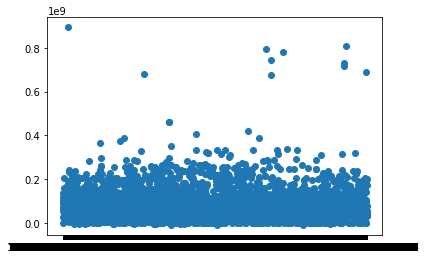

In [33]:
plt.scatter(y,predicted3)

R2 is increasing and also Adjusted R2.
This means that the model is improving. 


In [34]:
A=df.copy()

In [45]:
df=A.copy()

## Challenge 4
Enhance your model further by adding more features and/or transforming existing features. Think about how you build the model matrix and how to interpret what the model is doing.


In [46]:
import numpy as np
#let's apply the box-cox transformation
columns_to_keep=["domestic_gross_clnd_adj", "budget_adj"]
columns_to_keep.extend(genres)

df = df.dropna(subset=columns_to_keep)

from sklearn import preprocessing
from scipy import stats
lambdas_dict=dict()
def optimal_lambda(x):
    return(np.max(stats.boxcox_normmax(x, method='all')))

def box_cox_mine(x,lamb):
    if lmbda==0:
        return(log(x))
    else:
        return((x**lmbda - 1) / lmbda)
    
df[columns_to_keep]=preprocessing.normalize(df[columns_to_keep], axis=0)    

for column in columns_to_keep:
    try:
        
        lmbda=optimal_lambda(df[column])
        df[column]=df[column].apply(lambda x: box_cox_mine(x,lmbda))
        lambdas_dict[column]=lmbda
    except:
        continue
   
   

In [47]:
y, X = patsy.dmatrices(str_as_R, data=df, return_type="dataframe")

model = sm.OLS(y, X)
# Fit your model to your training set
fit4 = model.fit()
predicted4=fit4.predict(X)
# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     domestic_gross_clnd_adj   R-squared:                       0.431
Model:                                 OLS   Adj. R-squared:                  0.420
Method:                      Least Squares   F-statistic:                     41.84
Date:                     Sun, 28 Jan 2018   Prob (F-statistic):               0.00
Time:                             16:28:24   Log-Likelihood:                -588.27
No. Observations:                     3663   AIC:                             1309.
Df Residuals:                         3597   BIC:                             1718.
Df Model:                               65                                         
Covariance Type:                 nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.0475      0.058    -18.098      0.000      -1.161      -0.934
budget_adj             0.5939      0.019     31.031      0.000       0.556       0.631
Fantasy_Comedy         0.3574      0.286      1.250      0.211      -0.203       0.918
Horror                 1.8258      0.284      6.421      0.000       1.268       2.383
Horror_Thriller       -0.2142      0.286     -0.750      0.454      -0.775       0.346
Action_Comedy          0.0712      0.285      0.250      0.802      -0.487       0.629
Crime_Drama           -0.2198      0.285     -0.772      0.440      -0.778       0.338
Action_Thriller        0.2795      0.287      0.974      0.330      -0.283       0.842
Thriller               0.0236      0.281      0.084      0.933      -0.528       0.575
Family_Comedy          1.0303      0.285      3.616      0.000       0.472       1.589
Crime_Thriller        -0.6564      0.286     -2.294      0.022      -1.217      -0.095
Romantic_Thriller     -0.7243      0.286     -2.530      0.011      -1.286      -0.163
Action                -0.3742      0.286     -1.307      0.191      -0.935       0.187
Crime                 -0.4050      0.286     -1.417      0.157      -0.965       0.155
Action_Drama           0.0080      0.287      0.028      0.978      -0.555       0.571
Action___Crime        -0.2380      0.286     -0.833      0.405      -0.798       0.322
Crime_Comedy          -0.7147      0.285     -2.508      0.012      -1.273      -0.156
Adventure             -0.0552      0.288     -0.192      0.848      -0.620       0.509
Action___Adventure     0.8347      0.298      2.800      0.005       0.250       1.419
Drama___Thriller      -0.5729      0.284     -2.015      0.044      -1.130      -0.015
Unknown               -2.2576      0.294     -7.684      0.000      -2.834      -1.682
Comedy_Thriller       -0.8669      0.287     -3.025      0.003      -1.429      -0.305
Drama                 -0.1782      0.289     -0.618      0.537      -0.744       0.388
Comedy                 1.0385      0.274      3.792      0.000       0.501       1.575
Period_Drama          -0.4875      0.285     -1.709      0.088      -1.047       0.072
Horror_Comedy         -0.2872      0.285     -1.007      0.314      -0.846       0.272
Period_Comedy          0.5492      0.286      1.917      0.055      -0.013       1.111
Sci_Fi_Comedy         -0.8646      0.287     -3.014      0.003      -1.427      -0.302
Comedy___Drama         0.3509      0.285      1.231      0.218      -0.208       0.910
Romantic_Comedy       -0.0140      0.279     -0.050      0.960      -0.562       0.534
Action_Horror         -0.2818      0.286     -0.985      0.325      -0.843       0.279
Period_Action          0.0121      0.287      0.042      0.966      -0

Thanks to Box Cox, 
Omnibus has decreased a lot

Additionally, the model has a better R2 and Adj R2

## Challenge 5

Fitting and checking predictions on the exact same data set can be
misleading. Divide your data into two sets: a training and a test set
(roughly 75% training, 25% test is a fine split). Fit a model on the
training set, check the predictions (by plotting versus actual values)
in the test set.

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [54]:
model= LinearRegression()
model.fit(X_train,y_train)
predicted=model.predict(X_test)
model.score(X_test,y_test)


0.44111871594168456

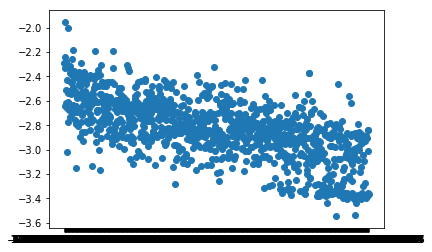

In [55]:
plt.scatter(y_test,predicted)